In [155]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from time import perf_counter

plt.style.use("seaborn-v0_8-whitegrid")

# Rutas
MODELS_DIR   = os.path.join("..", "models")
TRAIN_DIR    = os.path.join("..", "data", "raw", "train")
EXAMPLES_DIR = os.path.join("..", "examples")

PRIMARY_MODEL  = os.path.join(MODELS_DIR, "modelo_mobilenetv2_finetuned.keras")
FALLBACK_MODEL = os.path.join(".",        "modelo_mobilenetv2_finetuned.keras")
CLASS_CSV      = os.path.join(MODELS_DIR, "class_names.csv")
IMG_SIZE = (224, 224)
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def load_class_names():
    if os.path.isfile(CLASS_CSV):
        names = pd.read_csv(CLASS_CSV, header=None).iloc[:, 0].astype(str).tolist()
    else:
        names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
    if not names:
        raise RuntimeError("No se pudieron cargar clases desde `../models/class_names.csv` ni `../data/raw/train`.")
    return names

def load_model():
    path = PRIMARY_MODEL if os.path.isfile(PRIMARY_MODEL) else FALLBACK_MODEL
    if not os.path.isfile(path):
        raise FileNotFoundError("No se encontró el modelo en `../models/modelo_mobilenetv2_finetuned.keras` ni en `./modelo_mobilenetv2_finetuned.keras`.")
    print(f"Modelo cargado desde: {os.path.abspath(path)}")
    return tf.keras.models.load_model(path)

CLASS_NAMES = load_class_names()
model = load_model()

Modelo cargado desde: c:\Users\juanf\OneDrive\Escritorio\emociones-futbol\models\modelo_mobilenetv2_finetuned.keras


In [156]:
def list_images(folder):
    if not os.path.isdir(folder):
        return []
    files = [os.path.join(folder, f) for f in os.listdir(folder)]
    return sorted([p for p in files if os.path.splitext(p)[1].lower() in EXTS])


def preprocess_image(path, target_size=(224, 224)):
    img = Image.open(path).convert("RGB").resize(target_size)
    arr = np.array(img).astype("float32") / 255.0
    x = np.expand_dims(arr, axis=0)
    return x, img

def predict_image(model, image_path, topk=3):
    x, pil_img = preprocess_image(image_path, IMG_SIZE)
    t0 = perf_counter()
    probs = model.predict(x, verbose=0)[0]
    dt = perf_counter() - t0
    k = min(topk, len(CLASS_NAMES))
    idx_top = np.argsort(probs)[::-1][:k]
    return pil_img, probs, idx_top, dt

def plot_top3_bars(probs, idx_top, title="Top‑3 probabilidades"):
    labels = [CLASS_NAMES[i] for i in idx_top]
    vals = probs[idx_top]
    plt.figure(figsize=(4.5, 2.8))
    plt.bar(labels, vals, color="#4C72B0")
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("confianza")
    plt.tight_layout()
    plt.show()


Imagen: c:\Users\juanf\OneDrive\Escritorio\emociones-futbol\examples\16240250776800.jpg
Predicción Top‑1: angry (conf=0.4577) · tiempo=2014.5 ms


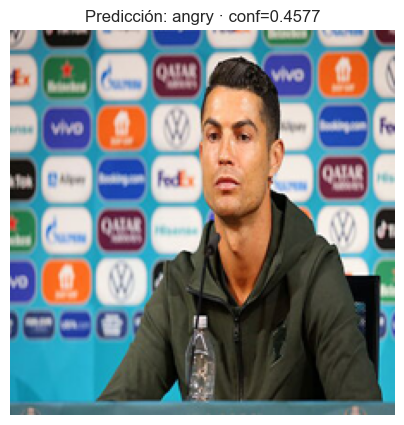

C:\Users\juanf\AppData\Local\Temp\ipykernel_14308\611266264.py:31: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\juanf\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


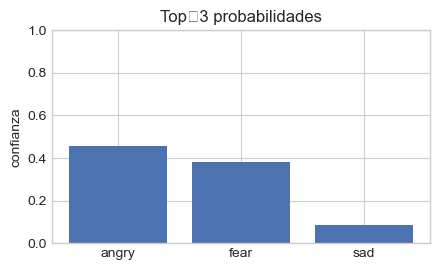

In [157]:
images = list_images(EXAMPLES_DIR)
if not images:
    raise FileNotFoundError("No hay imágenes en `../examples`. Coloca archivos .jpg/.png para continuar.")

sample_path = images[0]
pil_img, probs, idx_top, dt = predict_image(model, sample_path, topk=3)
top1 = idx_top[0]
print(f"Imagen: {os.path.abspath(sample_path)}")
print(f"Predicción Top‑1: {CLASS_NAMES[top1]} (conf={probs[top1]:.4f}) · tiempo={dt*1000:.1f} ms")

plt.figure(figsize=(5, 5))
plt.imshow(pil_img); plt.axis("off")
plt.title(f"Predicción: {CLASS_NAMES[top1]} · conf={probs[top1]:.4f}")
plt.show()

plot_top3_bars(probs, idx_top)

#,Emoción,Probabilidad,Confianza (%)
1,angry,0.4577,45.77
2,fear,0.3826,38.26
3,sad,0.0833,8.33
#,Emoción,Probabilidad,Confianza (%)
1,fear,0.5892,58.92
2,sad,0.2345,23.45
3,angry,0.1282,12.82
#,Emoción,Probabilidad,Confianza (%)
1,sad,0.3027,30.27
2,angry,0.2579,25.79

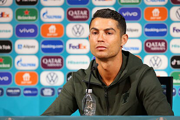
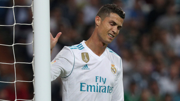
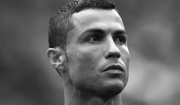
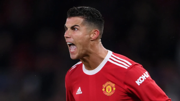
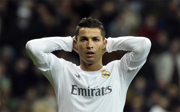
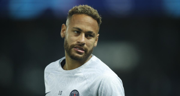
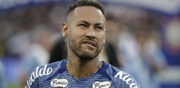
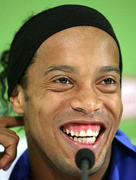
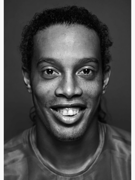

In [ ]:
from IPython.display import display, HTML
import base64
from io import BytesIO


html_output = """
<h3 style='text-align:center; color:#e2e8f0; background:#111; 
padding:10px; border-radius:10px; font-family:Segoe UI;'>
Resultados detallados por imagen
</h3>
"""

for img_name, df_g in df_top3.groupby("imagen"):
    img_path = [p for p in images if os.path.basename(p) == img_name]
    if not img_path:
        continue
    img_path = img_path[0]

    # Convertir imagen a base64 para mostrar en HTML
    with Image.open(img_path) as im:
        im.thumbnail((180, 180))
        buffer = BytesIO()
        im.save(buffer, format="PNG")
        img_b64 = base64.b64encode(buffer.getvalue()).decode()

    # Formatear tabla
    df_tmp = df_g[['rank', 'clase', 'prob', 'conf_porcentaje']].copy()
    df_tmp.columns = ['#', 'Emoción', 'Probabilidad', 'Confianza (%)']
    df_tmp['Probabilidad'] = df_tmp['Probabilidad'].astype(float).map("{:.4f}".format)
    df_tmp['Confianza (%)'] = df_tmp['Confianza (%)'].astype(float).map("{:.2f}".format)

    table_html = df_tmp.to_html(
        index=False,
        border=0,
        justify='center',
        classes='styled-table',
        escape=False
    )

    html_output += f"""
    <div style='display:flex; align-items:center; gap:20px; border:1px solid #333; 
                border-radius:10px; padding:15px; margin:20px 0; background:#1a1a1a;'>
        <img src="data:image/png;base64,{img_b64}" 
             style='border-radius:8px; border:2px solid #444; width:180px; height:auto;'/>
        <div style='flex:1'>
            <h4 style='margin:5px 0 10px 0; color:#00b4d8; font-weight:bold; 
                       font-family:Segoe UI;'>{img_name}</h4>
            {table_html}
        </div>
    </div>
    """
    
css_style = """
<style>
    .styled-table {
        border-collapse: collapse;
        font-size: 14px;
        font-family: 'Segoe UI', sans-serif;
        width: 100%;
        text-align: center;
        border-radius: 8px;
        overflow: hidden;
        color: #f1f1f1;
        background-color: #202020;
    }
    .styled-table th {
        background-color: #00b4d8;
        color: white;
        padding: 10px;
        font-weight: bold;
        border-bottom: 2px solid #0077b6;
    }
    .styled-table td {
        padding: 8px;
        font-weight: 600;
        border-bottom: 1px solid #333;
    }
    .styled-table tr:nth-child(even) {
        background-color: #2a2a2a;
    }
    .styled-table tr:hover {
        background-color: #333;
    }
</style>
"""

display(HTML(css_style + html_output))
